In [1]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt

# SHAPER
from src.Observables import Observable
from src.CommonObservables import NSubjettiness
from src.Shaper import Shaper
from src.Manifolds import Coordinates2D, Simplex, PositiveReals

# Utils
from utils.data_utils import load_cmsopendata
from utils.plot_utils import plot_event, plot_hist

# Jets
from pyjet import cluster


# GPU nonsense
import torch 
import torch.nn as nn

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 



/home/rikab/miniconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Using CPU!


# Data

Max # of particles: 110
Max # of particles: 86
test


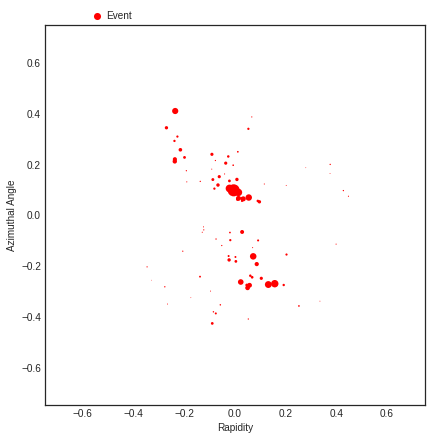

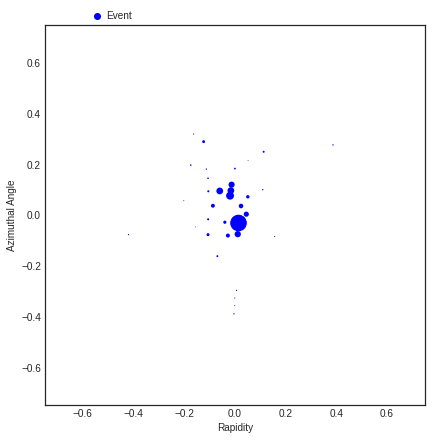

<AxesSubplot:xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [2]:
# Parameters
R = 0.5
beta = 1.0
N = 100
batch_size = min(500,N)
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"

# Load CMS OpenData and weights
cms, cms_weights = load_cmsopendata("data", "cms", pt_lower, pt_upper, eta, quality, pad, n = N)
sim, sim_weights, sim_factors = load_cmsopendata("data", "sim", pt_lower, pt_upper, eta, quality, pad, n = N)
sim_weights = sim_weights * sim_factors



# Example plots, for fun
example_cms = cms[0]
plot_event(example_cms[0], example_cms[1], R, color = "red")

example_sim = sim[0]
plot_event(example_sim[0], example_sim[1], R, color = "blue")

BATCH: 0
Observable: 1 Point-Ringiness Epoch 0 Mean Loss = 0.05345044101588428 Elapsed time = 2.516s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 1 Mean Loss = 0.0516687051858753 Elapsed time = 4.057s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 2 Mean Loss = 0.04889568902552128 Elapsed time = 5.554s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 3 Mean Loss = 0.047524822596460584 Elapsed time = 7.038s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 4 Mean Loss = 0.04740652895066887 Elapsed time = 8.555s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 5 Mean Loss = 0.04709228990599513 Elapsed time = 10.037s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 6 Mean Loss = 0.04611996744759381 Elapsed time = 11.521s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 7 Mean Loss = 0.04601287961937487 Elapsed time = 13.002s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 8 Mean Loss = 0.

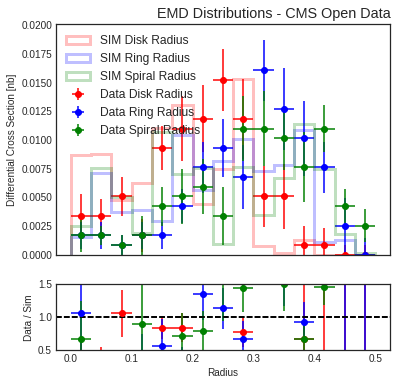

In [3]:
import torch 
import torch.nn as nn

from matplotlib.patches import Circle as pltCircle
from matplotlib.collections import PathCollection



# Basic Observables, prebuilt!
_1subjettiness = NSubjettiness(1, beta = 1, R = R)
_2subjettiness = NSubjettiness(2, beta = 1, R = R)
_3subjettiness = NSubjettiness(3, beta = 1, R = R)


# Advanced Observables: Define a sampler and an (optional) plotter
def point_ring_sampler(N, param_dict):
    center = param_dict["Points"].params
    radius = param_dict["Radius"].params
    weights = param_dict["Structure Weights"].params

    phi = 2 * np.pi * torch.rand(N)
    points = torch.stack([torch.cos(phi), torch.sin(phi)], axis = 1) * radius + center

    # Concatenate and reweight
    e = torch.cat([center, points], dim = 0)
    z = torch.cat([weights[0] * torch.ones((1,)), weights[1] * torch.ones((N,)) / N], dim = 0)

    return (e, z)
    

def point_ring_plotter(ax, param_dict):

    center = param_dict["Points"].params.clone().detach().numpy()
    radius = param_dict["Radius"].params.clone().detach().numpy()
    weights = param_dict["Structure Weights"].params.clone().detach().numpy()

    # Ring
    draw_circle = pltCircle(center[0,:], radius[0], facecolor = None, edgecolor = "purple", fill = False,)
    ax.add_artist(draw_circle)

    # Center
    ax.scatter(center[:,0], center[:,1], color = "Purple", label = "Ring", marker = "x", s = 2 * weights[0] * 500/np.sum(weights), alpha = 0.5)
    
    # # Points
    # e, z = point_ring_sampler(50, param_dict)
    # e = e.clone().detach().numpy()
    # z = z.clone().detach().numpy()
    # ax.scatter(e[:,0], e[:,1], color = "Purple", s = 2 * z * 500/np.sum(z), alpha = 0.25)

    # Text
    plt.text(0.05, 0.06 + 0.03*0, "Point: (%.3f, %.3f), Weight: %.3f, Radius: %.3f" % (center[0,0], center[0,1], weights[0], radius[0]), fontsize = 10, transform = plt.gca().transAxes)


def point_disk_sampler(N, param_dict):
    center = param_dict["Points"].params
    radius = param_dict["Radius"].params
    weights = param_dict["Structure Weights"].params

    phi = 2 * np.pi * torch.rand(N)
    r =  torch.sqrt(torch.rand(N))
    points = torch.stack([torch.cos(phi), torch.sin(phi)], axis = 1) * radius * r[:,None] + center


    # Concatenate and reweight
    e = torch.cat([center, points], dim = 0)
    z = torch.cat([weights[0] * torch.ones((1,)), weights[1] * torch.ones((N,)) / N], dim = 0)

    return (e, z)


def point_disk_plotter(ax, param_dict):

    center = param_dict["Points"].params.clone().detach().numpy()
    radius = param_dict["Radius"].params.clone().detach().numpy()
    weights = param_dict["Structure Weights"].params.clone().detach().numpy()

    # Circle
    draw_circle = pltCircle(center[0,:], radius[0], facecolor = "purple", edgecolor = "purple", alpha = 0.25)
    ax.add_artist(draw_circle)

    # # Points
    # e, z = point_disk_sampler(50, param_dict)
    # e = e.clone().detach().numpy()
    # z = z.clone().detach().numpy()
    # ax.scatter(e[:,0], e[:,1], color = "Purple", s = 2 * z * 500/np.sum(z), alpha = 0.25)

    # Center
    ax.scatter(center[:,0], center[:,1], color = "Purple", label = "Disk", marker = "x", s = 2 * weights[0] * 500/np.sum(weights), alpha = 0.5)
    
    # Text
    plt.text(0.05, 0.06 + 0.03*0, "Point: (%.3f, %.3f), Weight: %.3f, Radius: %.3f" % (center[0,0], center[0,1], weights[0], radius[0]), fontsize = 10, transform = plt.gca().transAxes)




def point_spiral_sampler(N, param_dict):
    center = param_dict["Points"].params
    radius = param_dict["Radius"].params
    winding = param_dict["Winding"].params
    weights = param_dict["Structure Weights"].params

    phi = 2 * np.pi * torch.rand(N).to(device)
    r =  radius * np.sqrt(phi / 2 / np.pi)

    points = torch.stack([torch.cos(winding * phi), torch.sin(winding * phi)], axis = 1) * r[:,None] + center

    # Concatenate and reweight
    e = torch.cat([center, points], dim = 0)
    z = torch.cat([weights[0] * torch.ones((1,), device=device), weights[1] * torch.ones((N,), device=device) / N], dim = 0)

    return (e, z)


def point_spiral_plotter(ax, param_dict):

    center = param_dict["Points"].params.clone().detach().numpy()
    radius = param_dict["Radius"].params.clone().detach().numpy()
    winding = param_dict["Winding"].params.clone().detach().numpy()
    weights = param_dict["Structure Weights"].params.clone().detach().numpy()

    # Spiral
    phi = np.linspace(0, 2 * np.pi, 100)
    r = radius * np.sqrt(phi / 2 / np.pi)
    x = r*np.cos(winding * phi)
    y = r*np.sin(winding * phi)
    plt.plot(x[:,None] + center, y[:,None] + center, color = "purple", alpha = 0.5)

    # # Points
    # e, z = point_spiral_sampler(50, param_dict)
    # e = e.clone().detach().numpy()
    # z = z.clone().detach().numpy()
    # ax.scatter(e[:,0], e[:,1], color = "Purple", s = 2 * z * 500/np.sum(z), alpha = 0.25)

    # Center
    ax.scatter(center[:,0], center[:,1], color = "Purple", label = "Disk", marker = "x", s = 2 * weights[0] * 500/np.sum(weights), alpha = 0.5)
    
    # Text
    plt.text(0.05, 0.06 + 0.03*0, "Point: (%.3f, %.3f), Weight: %.3f, Radius: %.3f" % (center[0,0], center[0,1], weights[0], radius[0]), fontsize = 10, transform = plt.gca().transAxes)


_point_ringiness = Observable({"Points" : Coordinates2D(1), "Structure Weights" : Simplex(2), "Radius" : PositiveReals(1, R/2)}, point_ring_sampler, beta = 1, R = R, initializer= "kt", plotter = point_ring_plotter)
_point_diskiness = Observable({"Points" : Coordinates2D(1), "Structure Weights" : Simplex(2), "Radius" : PositiveReals(1, R/2)}, point_disk_sampler, beta = 1, R = R, initializer= "kt", plotter = point_disk_plotter)
_point_spiraliness = Observable({"Points" : Coordinates2D(1), "Structure Weights" : Simplex(2), "Radius" : PositiveReals(1, R/2), "Winding" : PositiveReals(1, 1)}, point_spiral_sampler, beta = 1, R = R, initializer= "kt", plotter = point_spiral_plotter)

# List of observables we want to calculate
observables = {
    # "2 Subjettiness" : _2subjettiness,
    "1 Point-Ringiness" : _point_ringiness,
    "1 Point-Diskiness" : _point_diskiness,
    "1 Point-Spiraliness" : _point_spiraliness,
}
shaper = Shaper(observables)


batches = int(N / batch_size)



cms_emd = [[],[],[]]
sim_emd = [[],[],[]]

cms_rad = [[],[],[]]
sim_rad = [[],[],[]]


plot_dictionary = {
    "plot_directory" : "Plots/Test",
    "gif_directory" : None,  
    "extension" : "png",
}

for batch in range(batches):

    print("BATCH: %d" % batch)
    start = batch * batch_size
    end = (batch + 1) * batch_size
    cms_emds, cms_params = shaper.calculate(cms[start:end], epochs = 500, verbose=True, lr = 0.01, N = 250, scaling = 0.75, epsilon = 0.01, early_stopping= 25, plot_dictionary=plot_dictionary)
    sim_emds, sim_params = shaper.calculate(sim[start:end], epochs = 500, verbose=True, lr = 0.01, N = 250, scaling = 0.75, epsilon= 0.01, early_stopping= 25)

    # Get values of observables
    for i in range(batch_size):
        for (j,obs) in enumerate(observables):

            cms_rad[j].append(cms_params[obs][i]["Radius"].params.detach().numpy()[0])
            sim_rad[j].append(sim_params[obs][i]["Radius"].params.detach().numpy()[0])

            cms_emd[j].append(cms_emds[obs][i])
            sim_emd[j].append(sim_emds[obs][i])



    gridspec_kw = {'height_ratios': (3.5, 1) }

    fig, axes = plt.subplots(2,  gridspec_kw=gridspec_kw,figsize=(6,6))
    plt.rcParams['font.size'] = '12'

    counts,bin_edges = plot_hist(axes, cms_rad[0], cms_weights, sim_rad[0], sim_weights, [0,R], "red", "Disk Radius", 'Radius', 15)
    counts,bin_edges = plot_hist(axes, cms_rad[1], cms_weights, sim_rad[1], sim_weights, [0,R], "blue", "Ring Radius", 'Radius', 15)
    counts,bin_edges = plot_hist(axes, cms_rad[2], cms_weights, sim_rad[2], sim_weights, [0,R], "green", "Spiral Radius", 'Radius', 15)

    plt.show()


In [4]:
print(cms_emd[1])



fig, axes = plt.subplots(2,  gridspec_kw=gridspec_kw,figsize=(6,6))
plt.rcParams['font.size'] = '12'

counts,bin_edges = plot_hist(axes, cms_rad[0], cms_weights, sim_rad[0], sim_weights, [0,R], "red", "Disk Radius", 'Radius', 15)
counts,bin_edges = plot_hist(axes, cms_rad[1], cms_weights, sim_rad[1], sim_weights, [0,R], "blue", "Ring Radius", 'Radius', 15)
counts,bin_edges = plot_hist(axes, cms_rad[2], cms_weights, sim_rad[2], sim_weights, [0,R], "green", "Spiral Radius", 'Radius', 15)
plt.savefig("Radii.png")
plt.close()

fig, axes = plt.subplots(2,  gridspec_kw=gridspec_kw,figsize=(6,6))
plt.rcParams['font.size'] = '12'

counts,bin_edges = plot_hist(axes, cms_emd[0], cms_weights, sim_emd[0], sim_weights, [0,.005], "red", "Disk EMD", 'EMD', 15)
counts,bin_edges = plot_hist(axes, cms_emd[1], cms_weights, sim_emd[1], sim_weights, [0,.005], "blue", "Ring EMD", 'EMD', 15)
counts,bin_edges = plot_hist(axes, cms_emd[2], cms_weights, sim_emd[2], sim_weights, [0,.005], "green", "Spiral EMD", 'EMD', 15)
plt.savefig("EMD.png")
plt.close()



[0.10149312019348145, 0.05568883568048477, 0.01684020832180977, 0.08123040199279785, 0.0651300698518753, 0.02042398601770401, 0.011407202109694481, 0.011343004181981087, 0.15378236770629883, 0.04257194697856903, 0.0064615532755851746, 0.06078772246837616, 0.03399347513914108, 0.025040876120328903, 0.006981410551816225, 0.020859509706497192, 0.10351911187171936, 0.023746758699417114, 0.015467146411538124, 0.004657127428799868, 0.04270540922880173, 0.0112982876598835, 0.08682291954755783, 0.018414514139294624, 0.02236150950193405, 0.04859255999326706, 0.010833628475666046, 0.019851651042699814, 0.01238967850804329, 0.033911556005477905, 0.018773050978779793, 0.0038527376018464565, 0.039175987243652344, 0.008706539869308472, 0.02149149216711521, 0.014414606615900993, 0.019159384071826935, 0.08615870773792267, 0.029156183823943138, 0.03799205273389816, 0.019157961010932922, 0.08705036342144012, 0.03380199521780014, 0.01116831973195076, 0.022395215928554535, 0.09087236225605011, 0.006867456

In [5]:


counts,bin_edges = plot_hist(cms_disk_rad, sim_disk_rad, "red", "Disk Radius", "Radius", [0,R])
counts,bin_edges = plot_hist(cms_ring_rad, sim_ring_rad, "blue", "Ring Radius", "Radius", [0,R])
plt.savefig("Radii.png")

counts,bin_edges = plot_hist(cms_disk_emd, sim_disk_rad, "red", "Disk EMD", "EMD", [0,.25])
counts,bin_edges = plot_hist(cms_ring_emd, sim_ring_rad, "blue", "Ring EMD", "EMD", [0,.25])
plt.savefig("Radii.png")


NameError: name 'cms_disk_rad' is not defined

0.02580122304614632
0.029109728471375995


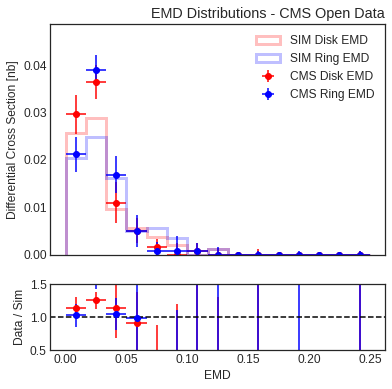

In [ ]:
n = len(cms_disk_emd)

lims = [0, .25]

gridspec_kw = {'height_ratios': (3.5, 1) }

fig, axes = plt.subplots(2,  gridspec_kw=gridspec_kw,figsize=(6,6))
plt.rcParams['font.size'] = '12'

def plot_hist(cms_arr, sim_arr, color, label):

    bins = 15
    counts,bin_edges = np.histogram(cms_arr,bins = bins, range = lims, weights= cms_weights[:n])
    sim_counts, sim_egdges = np.histogram(sim_arr,bins = bins, range = lims, weights= sim_weights[:n] * sim_factors[:n])
    step = bin_edges[1] - bin_edges[0]
    errs2 = np.histogram(cms_arr, bins=bins, weights=cms_weights[:n]*cms_weights[:n])[0]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    axes[0].errorbar(bin_centres, counts, yerr = np.sqrt(errs2), xerr = step / 2, fmt='o', color = color, label = r"CMS " + label)
    axes[0].hist(sim_arr, bins = bins, weights = sim_weights[:n] * sim_factors[:n], range = lims, color = color, alpha = 0.25, lw = 3, histtype= "step", label = r"SIM " + label)
    
    reg = 1e-6
    axes[1].errorbar(bin_centres, counts / (sim_counts + reg), xerr = step / 2, yerr = np.sqrt(errs2) / (sim_counts + reg), color = color, fmt = 'o')
    
    print(np.average(cms_arr, weights= cms_weights))
    
    return counts, bin_edges


counts,bin_edges = plot_hist(cms_disk_emd, sim_disk_emd, "red", "Disk EMD")
counts,bin_edges = plot_hist(cms_ring_emd, sim_ring_emd, "blue", "Ring EMD")


xlabel = r'EMD'
ylabel = 'Differential Cross Section [nb]'

for ax in axes:
        ax.minorticks_on()
        ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')

axes[0].tick_params(labelbottom=False)
axes[1].set_xlabel(xlabel)
axes[0].set_ylabel(ylabel)
axes[1].set_ylabel("Data / Sim")

axes[0].set_ylim([0.0, 1.25 * np.max(counts)])
axes[1].set_ylim([0.5, 1.5])
axes[1].axhline(1.0, color = "black", ls = "--")

axes[0].set_title('EMD Distributions - CMS Open Data', loc = "right")
axes[0].legend()

plt.savefig("EMD.png")